# Desafio: Consumo de Dados para Previsão do Tempo das Cidades do Vale do Paraíba.

## Objetivo

Avaliar conhecimentos nas linguagens Python e SQL e na engine de processamento Apache Spark.

## Descrição

Neste desafio, você desenvolverá um notebook que será responsável por extrair dados de previsão do tempo das cidades do Vale do Paraíba, região onde se localiza a Dataside. Para consultar todas as cidades dessa região, utilizaremos a API do IBGE. No caso, basta realizar uma requisição HTTP com o método GET, utilizando a URL abaixo:

```
https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes/3513/municipios
```

Com esses dados, gerar um data frame e a partir dele uma temp view. Ex: "cities"

Utilizando os nomes das cidades, deverão ser consultados os dados de previsão de tempo para cada cidade. Para realizar essa consulta, poderá ser utilizada qualquer uma das APIs informadas no link abaixo.

[Public APIs - Wather](https://github.com/public-apis/public-apis#weather)

Obs.: Para algumas, pode ser necessário cadastrar-se para acessar sua API Key. Mas nenhuma delas deve precisar cadastrar cartão de crédito ou adicionar qualquer valor monetário para utilizar. Caso alguma solicite, basta optar por outra.

Com os dados consultados, gerar um data frame e partir dele outra temp view. Ex: "forecasts"

Com as temp views geradas, utilizar Spark SQL para criar queries e gerar data frames das seguintes tabelas:

- Tabela 1: dados de previsão do tempo para os próximos cinco dias, para cada data e cidade consultadas. As colunas dessa tabela serão:
    - Cidade
    - CodigoDaCidade
    - Data
    - Regiao
    - Pais
    - Latitude
    - Longigute
    - TemperaturaMaxima
    - TemperaturaMinima
    - TemperaturaMedia
    - VaiChover
    - ChanceDeChuva
    - CondicaoDoTempo
    - NascerDoSol
    - PorDoSol
    - VelocidadeMaximaDoVento
    
    Obs.: Os valores da coluna "VaiChover" deverá ser "Sim" ou "Não". E a coluna "CodigoDaCidade" é o ID retornado junto com os nomes da cidades na API do IBGE.
    Obs.: Dependendo da API utilizada, algumas colunas podem não existir e ficarão em branco. Você deve optar por uma API que traga o maior número de informações possível.

- Tabela 2: quantidade de dias com chuva e sem chuva para os dias consultados, para cada data consultada. Colunas:
    - Cidade
    - QtdDiasVaiChover
    - QtdDiasNaoVaiChover
    - TotalDiasMapeados

Essas tabelas deverão ser exportadas em formado CSV e entregue no final do desafio.

## To Do

[ ] - Consultar municípios do Vale do Paraíba, gerar um data frame e criar uma temp view com esses dados.
[ ] - Consultar dados do tempo para cada município, gerar um data frame e criar uma outra temp view.
[ ] - Utilizar Spark SQL para gerar os data frames das Tabelas 1 e 2.
[ ] - Exportar os data frames para CSV.

## Atenção

- Existe um limite de requisições de 10000 requests por conta cadastrada na m3o.
- Essa API pode retornar cidades de outras regiões que possuem nome semelhante a alguma cidade do Vale do Paraiba. Pode mantê-las ou filtrar para gerar as tabelas apenas com dados de Regiao = Sao Paulo. Fica a seu critério.

## Entregando o desafio

Concluindo todos os passos informados em To Do, basta salvar o arquivo .ipynb do notebook e enviar para a Dataside juntamente com os CSVs das duas tabelas.


In [1]:
#Bibliotecas

# pyspark
!pip install pyspark

# findspark
!pip install findspark

# jupyterlab
!pip install jupyterlab

# unicode
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=8b8814b5be9c2836ea4a116b87296818f4aeebf744227f98e78a9df7a799c973
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import findspark
findspark.init()

import requests
import json
import unidecode
from pyspark.sql import SparkSession

spark = SparkSession.builder \
      .master("local[1]") \
      .appName("SparkByExamples.com") \
      .getOrCreate()

#Contexto

- O vale da Paraíba, um acidente geográfico natural, se destaca por concentrar uma parcela considerável do PIB do Brasil. Nele engloba cidades de São Paulo e Rio de Janeiro, porém, neste nosso estudo iremos abordar somente as cidades paulistas.

- Em nossa primeira pesquisa, traremos informações geográficas dos 39 municípios como, nome, estado, microrregião, entre outras. O nosso objetivo é fazer uma tabela com todas essas informações, assim poderemos fazer uma pesquisa do clima na região, assim como ver a previsão do tempo.

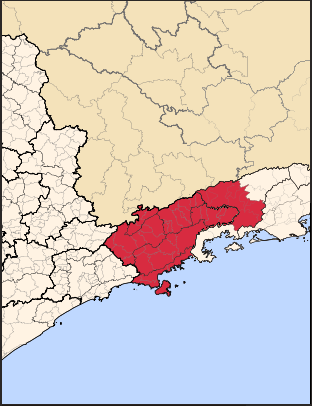

Mesorregião do Vale do Paraíba Paulista

In [3]:
# Buscar cidades do Vale do Paraíba
ibge = requests.get("https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes/3513/municipios").json()
ibge

[{'id': 3502507,
  'nome': 'Aparecida',
  'microrregiao': {'id': 35051,
   'nome': 'Guaratinguetá',
   'mesorregiao': {'id': 3513,
    'nome': 'Vale do Paraíba Paulista',
    'UF': {'id': 35,
     'sigla': 'SP',
     'nome': 'São Paulo',
     'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}},
  'regiao-imediata': {'id': 350052,
   'nome': 'Guaratinguetá',
   'regiao-intermediaria': {'id': 3511,
    'nome': 'São José dos Campos',
    'UF': {'id': 35,
     'sigla': 'SP',
     'nome': 'São Paulo',
     'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}}},
 {'id': 3503158,
  'nome': 'Arapeí',
  'microrregiao': {'id': 35052,
   'nome': 'Bananal',
   'mesorregiao': {'id': 3513,
    'nome': 'Vale do Paraíba Paulista',
    'UF': {'id': 35,
     'sigla': 'SP',
     'nome': 'São Paulo',
     'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}},
  'regiao-imediata': {'id': 350053,
   'nome': 'Cruzeiro',
   'regiao-intermediaria': {'id': 3511,
    'nome': 'São José dos Campos',
   

In [4]:
#lista com informações das cidades do Vale do Paraíba
list_df_ibge = []
for i in range(len(ibge)):
    list_df_ibge.append([ibge[i]['id'],
                        ibge[i]['nome'],
                        ibge[i]['microrregiao']['nome'],
                        ibge[i]['microrregiao']['mesorregiao']['nome'],
                        ibge[i]['microrregiao']['mesorregiao']['UF']['sigla'],
                        ibge[i]['microrregiao']['mesorregiao']['UF']['nome'],
                        ibge[i]['microrregiao']['mesorregiao']['UF']['regiao']['sigla'],
                        ibge[i]['microrregiao']['mesorregiao']['UF']['regiao']['nome']])

In [5]:
ibge[i]

{'id': 3555406,
 'nome': 'Ubatuba',
 'microrregiao': {'id': 35054,
  'nome': 'Caraguatatuba',
  'mesorregiao': {'id': 3513,
   'nome': 'Vale do Paraíba Paulista',
   'UF': {'id': 35,
    'sigla': 'SP',
    'nome': 'São Paulo',
    'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}},
 'regiao-imediata': {'id': 350051,
  'nome': 'Caraguatatuba - Ubatuba - São Sebastião',
  'regiao-intermediaria': {'id': 3511,
   'nome': 'São José dos Campos',
   'UF': {'id': 35,
    'sigla': 'SP',
    'nome': 'São Paulo',
    'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}}}

# Tabela das Cidades

In [6]:
# Criar Pandas data frame com as cidades
df_ibge = pd.DataFrame(list_df_ibge, columns=['id_city','name_city','name_micro_region','name_messo_region',
                                                 'Abbreviation_state','name_state','Abbreviation_region','name_region'])
df_ibge

,id_city,name_city,name_micro_region,name_messo_region,Abbreviation_state,name_state,Abbreviation_region,name_region
0,3502507,Aparecida,Guaratinguetá,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
1,3503158,Arapeí,Bananal,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
2,3503505,Areias,Bananal,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
3,3504909,Bananal,Bananal,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
4,3508504,Caçapava,São José dos Campos,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
5,3508603,Cachoeira Paulista,Guaratinguetá,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
6,3509700,Campos do Jordão,Campos do Jordão,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
7,3509957,Canas,Guaratinguetá,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
8,3510500,Caraguatatuba,Caraguatatuba,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste
9,3513405,Cruzeiro,Guaratinguetá,Vale do Paraíba Paulista,SP,São Paulo,SE,Sudeste


- Depois de analisado os sites de pesquisas da previsão do tempo, concluímos que não será possível buscar informações do clima para todas estas cidades, assim resolvemos retirar a cidade de Potim da nossa tabela. Esta estava nos causando um erro no código e não seria possível prosseguir com o estudo.

In [7]:
# dataframe sem uma cidade - Não foi possível localiza-lá nas cidades para previsão do tempo
df_ibge2 = df_ibge.drop(index=[24]).reset_index(drop=True)

- Em outro momento de nossa análise verificamos que algumas cidades não estavam sendo encontradas pela falta de padronização, principalmente pelo acento em alguns nomes de cidades, então iremos usar uma normalização para corrigir isso.

In [8]:
# Limpeza nos nomes das cidades para encontrar nas previsões do tempo
df_ibge2.name_city = df_ibge2.name_city.str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

In [9]:
# Criar spark data frame com as cidades
df_spark_ibge = spark.createDataFrame(df_ibge2)
df_spark_ibge.show(39)

+-------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+
|id_city|           name_city|   name_micro_region|   name_messo_region|Abbreviation_state|name_state|Abbreviation_region|name_region|
+-------+--------------------+--------------------+--------------------+------------------+----------+-------------------+-----------+
|3502507|           Aparecida|       Guaratinguetá|Vale do Paraíba P...|                SP| São Paulo|                 SE|    Sudeste|
|3503158|              Arapei|             Bananal|Vale do Paraíba P...|                SP| São Paulo|                 SE|    Sudeste|
|3503505|              Areias|             Bananal|Vale do Paraíba P...|                SP| São Paulo|                 SE|    Sudeste|
|3504909|             Bananal|             Bananal|Vale do Paraíba P...|                SP| São Paulo|                 SE|    Sudeste|
|3508504|            Cacapava| São José dos Campos|Vale

In [10]:
# Criar view com as cidades
df_spark_ibge.createOrReplaceTempView('cities')

  - Nesta etapa do estudo iremos fazer uma busca da previsão do tempo em todas as cidades do Vale da Paraíba presentes em nossa tabela com informações geográficas. 
  - Faremos uma busca na API WEATHERAPI e o programa retornará, em formato de tabela algumas informações do município, o horário/data da pesquisa, a previsão para o dia pesquisado e a previsão para os próximos 5 dias. 

# Tabela das Previsões

In [11]:
# Criar Pandas data frame com as previsões
list_weather_keys = []
for name_city in df_ibge2.name_city	:
  http_weather = 'http://api.weatherapi.com/v1/forecast.json?key=eec58040ec21402cabe173206232203&q='+name_city+'&days=6&aqi=no&alerts=no'
  weather_request = requests.get(http_weather).json()
  for i in range(6):
      list_weather_value = []
      for key, value in weather_request['location'].items(): 
            list_weather_value.append(value)
            if name_city == df_ibge2.name_city[0] and i == 0:
                list_weather_keys.append(key)
      list_weather_value.append(weather_request['forecast']['forecastday'][i]['date'])
      if name_city == df_ibge2.name_city[0] and i == 0:
          list_weather_keys.append('date')
      for key,value in weather_request['forecast']['forecastday'][i]['day'].items():
              if name_city == df_ibge2.name_city[0] and i == 0:
                  list_weather_keys.append(key)
                  df_weather = pd.DataFrame(columns = [list_weather_keys])
              if key == "condition":
                  list_weather_value.append(weather_request['forecast']['forecastday'][i]['day']['condition']['text'])
              else:
                  list_weather_value.append(value)   
      df_weather.loc[len(df_weather)] = list_weather_value 
df_weather

,name,region,country,lat,lon,tz_id,localtime_epoch,localtime,date,maxtemp_c,...,totalsnow_cm,avgvis_km,avgvis_miles,avghumidity,daily_will_it_rain,daily_chance_of_rain,daily_will_it_snow,daily_chance_of_snow,condition,uv
0,Aparecida,Sao Paulo,Brazil,-22.83,-45.23,America/Sao_Paulo,1680122408,2023-03-29 17:40,2023-03-29,28.6,...,0.0,6.3,3.0,90.0,1,88,0,0,Moderate rain,5.0
1,Aparecida,Sao Paulo,Brazil,-22.83,-45.23,America/Sao_Paulo,1680122408,2023-03-29 17:40,2023-03-30,31.0,...,0.0,6.5,4.0,88.0,1,84,0,0,Moderate rain,5.0
2,Aparecida,Sao Paulo,Brazil,-22.83,-45.23,America/Sao_Paulo,1680122408,2023-03-29 17:40,2023-03-31,28.0,...,0.0,6.7,4.0,88.0,1,87,0,0,Moderate rain,4.0
3,Aparecida,Sao Paulo,Brazil,-22.83,-45.23,America/Sao_Paulo,1680122408,2023-03-29 17:40,2023-04-01,31.4,...,0.0,7.3,4.0,85.0,1,87,0,0,Moderate rain,4.0
4,Aparecida,Sao Paulo,Brazil,-22.83,-45.23,America/Sao_Paulo,1680122408,2023-03-29 17:40,2023-04-02,23.8,...,0.0,7.5,4.0,94.0,1,89,0,0,Moderate rain,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Ubatuba,Sao Paulo,Brazil,-23.43,-45.07,America/Sao_Paulo,1680122424,2023-03-29 17:40,2023-03-30,33.1,...,0.0,8.6,5.0,86.0,1,82,0,0,Moderate rain,5.0
224,Ubatuba,Sao Paulo,Brazil,-23.43,-45.07,America/Sao_Paulo,1680122424,2023-03-29 17:40,2023-03-31,32.4,...,0.0,8.2,5.0,84.0,1,82,0,0,Patchy rain possible,5.0
225,Ubatuba,Sao Paulo,Brazil,-23.43,-45.07,America/Sao_Paulo,1680122424,2023-03-29 17:40,2023-04-01,33.8,...,0.0,9.6,5.0,82.0,1,88,0,0,Moderate rain,5.0
226,Ubatuba,Sao Paulo,Brazil,-23.43,-45.07,America/Sao_Paulo,1680122424,2023-03-29 17:40,2023-04-02,22.8,...,0.0,7.5,4.0,94.0,1,89,0,0,Moderate rain,5.0


- Como é possível ver na tabela acima, tabela das previsões, algumas cidades encontradas na API WEATHERAPI não pertencem ao vale da Paraíba. Desta maneira tínhamos duas opções, retirar estas do nosso estudo ou deixar as cidades de outros estados, regiões, assim optamos por deixar as cidades.
- Acreditamos que cidades de outras regiões não afetam o nosso estudo, por outo lado podem contribuir por trazer climas diferentes para a nossa análise.

- Em nossa tabela, temos a previsão se irá chover ou não, em determinada cidade, porém o '0' representa que não chove e o '1' representa o sim, que irá chover, então iremos fazer essa transformação para melhor entendimento.

In [12]:
# Subtituir 0 por "não" (não chove), e 1 por "sim" (chove)
df_weather['daily_will_it_rain'] = df_weather['daily_will_it_rain'].replace({0: 'não', 1: 'sim'})  

In [13]:
# Criar Spark data frame com as previsões
df_spark_weather = spark.createDataFrame(df_weather,list_weather_keys)
df_spark_weather.show()

+---------+---------+-------+------+------+-----------------+---------------+----------------+----------+---------+---------+---------+---------+---------+---------+-----------+-----------+--------------+--------------+------------+---------+------------+-----------+------------------+--------------------+------------------+--------------------+-------------+---+
|     name|   region|country|   lat|   lon|            tz_id|localtime_epoch|       localtime|      date|maxtemp_c|maxtemp_f|mintemp_c|mintemp_f|avgtemp_c|avgtemp_f|maxwind_mph|maxwind_kph|totalprecip_mm|totalprecip_in|totalsnow_cm|avgvis_km|avgvis_miles|avghumidity|daily_will_it_rain|daily_chance_of_rain|daily_will_it_snow|daily_chance_of_snow|    condition| uv|
+---------+---------+-------+------+------+-----------------+---------------+----------------+----------+---------+---------+---------+---------+---------+---------+-----------+-----------+--------------+--------------+------------+---------+------------+-----------+-

In [14]:
# Criar view com as previsões
df_spark_weather.createOrReplaceTempView('forecast')

- Após feitas todas as pesquisas e com as tabelas completas podemos criar as tabelas 1 e 2, conformes descritas no início deste documento.

In [15]:
# Criar DF da Tabela 1
tabela_1_df = spark.sql('SELECT f.name AS Cidade, \
                  c.id_city AS CodigoDaCidade, \
                  f.localtime AS DiaHora_Atual, \
                  f.date AS Data, \
                  c.name_region AS Regiao, \
                  c.name_state AS Estado, \
                  f.country AS Pais, \
                  f.lat AS Latitude, \
                  f.lon AS Longigute, \
                  f.maxtemp_c AS TemperaturaMaxima, \
                  f.mintemp_c AS TemperaturaMinima, \
                  f.avgtemp_c AS TemperaturaMedia, \
                  f.daily_will_it_rain AS VaiChover, \
                  f.daily_chance_of_rain AS ChanceDeChuva, \
                  f.condition AS CondicaoDoTempo, \
                  f.maxwind_mph AS VelocidadeMaximaDoVento \
          FROM forecast as f \
          JOIN cities as c \
          ON f.name = c.name_city')
tabela_1_df.show()

+---------+--------------+----------------+----------+-------+---------+------+--------+---------+-----------------+-----------------+----------------+---------+-------------+---------------+-----------------------+
|   Cidade|CodigoDaCidade|   DiaHora_Atual|      Data| Regiao|   Estado|  Pais|Latitude|Longigute|TemperaturaMaxima|TemperaturaMinima|TemperaturaMedia|VaiChover|ChanceDeChuva|CondicaoDoTempo|VelocidadeMaximaDoVento|
+---------+--------------+----------------+----------+-------+---------+------+--------+---------+-----------------+-----------------+----------------+---------+-------------+---------------+-----------------------+
|Aparecida|       3502507|2023-03-29 17:40|2023-03-29|Sudeste|São Paulo|Brazil|  -22.83|   -45.23|             28.6|             16.6|            20.7|      sim|           88|  Moderate rain|                    3.8|
|Aparecida|       3502507|2023-03-29 17:40|2023-03-30|Sudeste|São Paulo|Brazil|  -22.83|   -45.23|             31.0|             14.5|  

In [16]:
# Criar DF da Tabela 2
#TABELA 2
tabela_2_df = spark.sql("SELECT f.name AS Cidade, \
                  f.region AS Estado, \
                  COUNT(CASE WHEN f.daily_will_it_rain = 'sim' THEN 1 ELSE NULL END) AS QtdDiasVaiChover, \
                  COUNT(CASE WHEN f.daily_will_it_rain = 'não' THEN 1 ELSE NULL END) AS QtdDiasNaoVaiChover, \
                  COUNT(f.name) AS TotalDiasMapeados \
          FROM forecast as f \
          JOIN cities as c \
          ON f.name = c.name_city \
          GROUP BY 1,2")
tabela_2_df.show()

+------------------+------------+----------------+-------------------+-----------------+
|            Cidade|      Estado|QtdDiasVaiChover|QtdDiasNaoVaiChover|TotalDiasMapeados|
+------------------+------------+----------------+-------------------+-----------------+
|         Aparecida|   Sao Paulo|               6|                  0|                6|
|            Arapei|   Sao Paulo|               6|                  0|                6|
|            Areias|        Para|               5|                  1|                6|
|           Bananal|    Maranhao|               5|                  1|                6|
|          Cacapava|   Sao Paulo|               6|                  0|                6|
|Cachoeira Paulista|   Sao Paulo|               6|                  0|                6|
|             Canas|  Guanacaste|               0|                  6|                6|
|     Caraguatatuba|   Sao Paulo|               6|                  0|                6|
|             Cunha| 

Para finalizar o trabalho iremos exportar estas duas últimas tebelas e enviar juntas com o programa ao cliente.

In [17]:
# Exportar CSVs
tabela_1_df.write.csv('tabela_1.csv', header=True)
tabela_2_df.write.csv('tabela_2.csv', header=True)

#Conclusão

  - Após geradas as tabelas 1 e 2 e converter elas para CSV o trabalho está completo, porém, podemos destacar o quanto as cidades pertencentes ao Vale da Paraíba se parecem nas previsões climáticas, por estarem perto uma das outras, e as cidades que são de outros locais acabam tendo previsões bem diferentes.
  - O fato de termos previsões diferentes em nossa tabela exemplifica o quanto as cidades de fora da região enriqueceram a nossa análise. É muito provável que, se não tivesse nenhuma cidade de fora, as previsões seriam praticamente as mesmas.
  - Para finalizar este trabalho que serve para termos a previsão dos próximos 5 dias, toda a vez que este código for rodado a previsão será atualizada. Fico pensando quantas coisas não podemos fazer com um simples código como este, podemos trazer inúmeras informações para a população e quem se interessar.

 # Agradecimento 
 
 - Com esse trabalho pudemos trabalhar com API's, python e Spark. Eu nunca tinha feito nenhum trabalho utilizando pyspark, então gostei muito de poder fazer esse teste e aprender fazendo, que é o jeito que aprendo melhor.
  - Agradeço a oportunidade e espero poder realizar mais testes ou participar de outras etapas.